## Mini AlexNet 

### Comparison with Weight Regularized Results

Expects:

- weight.h5 files in ./weights 
- CIFAR10 data in ../data/cifar-10-batches-py/

and while the keras code needs py27, the notebooks can use py3.6 

In [1]:
import numpy as np
import pickle, time
from copy import deepcopy
from shutil import copy
import import_ipynb
from tqdm import tqdm_notebook as tqdm
import sys

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import keras
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K

import RMT_Util

print(sys.version)
print("numpy version {}".format(np.__version__))
print("tensforflow version {}".format(tf.__version__))
print("keras version {}".format(keras.__version__))

/Users/charleshmartin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


importing Jupyter notebook from RMT_Util.ipynb
3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.3
scipy version 1.1.0
tensforflow version 1.10.1
keras version 2.2.2
sklearn version 0.19.1
powerlaw version 1.4.3
3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
numpy version 1.14.3
tensforflow version 1.10.1
keras version 2.2.2


In [2]:
plt.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams.update({'font.size': 16})

In [3]:
DataDIR = "/Users/charleshmartin/work/DLGeneralization/data"
ModelDIR = "/Users/charleshmartin/work-tmp/MiniAlexNet"
WeightsDIR = ModelDIR+"/weights"
ResultsDIR = ModelDIR+"/results"

#### colors
https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib

In [4]:
DATA_DIR = DataDIR

BASELINE_outfile = ResultsDIR+'/cifar10_alexnet.out'
REGULARIZED_outfile = ResultsDIR+'/cifar10_alexnet.id1.wd.out'


BASELINE_final_weightfile = WeightsDIR+'/alexnet.b16.final.h5'
BASELINE_per_epoch_weightfile = WeightsDIR+"/alexnet.b16.e{}.h5"
NUM_BASELINE_EPOCHS = 100

BASELINE_init_weighfile = WeightsDIR+'/alexnet.b16.e0.h5'

BASELINE_ensemble_weightfile = WeightsDIR+"/alexnet.b16.id{}.final.h5"
NUM_ENSEBMBLE_RUNS = 10

REGULARIZED_final_weightfile = WeightsDIR+'/alexnet.b16.wd.final.h5'
REGULARIZED_per_epoch_weightfile = WeightsDIR+"/alexnet.b16.wd.e{}.h5"


N7, M7 = 4096, 384
N8, M8 = 384, 192

Q7 = float(N7)/float(M7)
Q8 = float(N8)/float(M8)

LAYER_FC1 = 7
LAYER_FC2 = 8

ENTROPY_FILE = "img/mini-alexnet-wd-entropy-per-epoch.png"
RANK_FILE = "img/mini-alexnet-wd-rank-per-epoch.png"
ACCURACY_FILE = "img/mini-alexnet-wd-accuracy-per-epoch.png"

TITLE_FC1 = "Mini AlexNet FC1: ESD\nw/Weight Regularization"
TITLE_FC2 = "Mini AlexNet FC2: ESD\nw/Weight Regularization"

XLABEL_FC1 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC1}^{T}\mathbf{W}_{FC1}$"
XLABEL_FC2 = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}_{FC2}^{T}\mathbf{W}_{FC2}$"

XLABEL = r"Eigenvalues $\lambda$ of $\mathbf{X}=\mathbf{W}}^{T}\mathbf{W}$"
YLABEL = "Spectral Density"

FC1_FILENAME = "img/mini-alexnet-wd-fc1.png"
FC2_FILENAME = "img/mini-alexnet-wd-fc2.png"

PHASE_5_1_TITLE = r"Singular ESD $\rho(\lambda)$"
PHASE_5_1_FILENAME = "img/phase51-singularity.png"

### check results are present

In [5]:
!ls $ResultsDIR/*wd*

/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.dp.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id1.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id10.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id2.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id3.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id4.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id5.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id6.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id7.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id8.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id9.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.r100.wd.out
/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alex

## Baseline 

In [6]:
model = RMT_Util.Alexnet_Model()

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
model.load_weights(BASELINE_final_weightfile)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

#### Check baseline shapes

In [8]:
for il, layer in enumerate(model.layers):
    weights = layer.get_weights() 
    if len(weights)>0 :
        W = weights[0]
        print("layer ",il,": ", W.shape)

layer  0 :  (5, 5, 3, 96)
layer  2 :  (96,)
layer  3 :  (5, 5, 96, 256)
layer  5 :  (256,)
layer  7 :  (4096, 384)
layer  8 :  (384, 192)
layer  9 :  (192, 10)


## BASELINE vs Weight Regularized

### Comparison of Entropies and Stable Ranks

In [9]:
fc1_entropies, fc2_entropies = [], []
fc1_ranks, fc2_ranks = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(BASELINE_per_epoch_weightfile.format(epoch))   
    fc1_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC1))
    fc2_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC2))
    
    fc1_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC1))
    fc2_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC2))

In [10]:
fc1_wd_entropies, fc2_wd_entropies = [], []
fc1_wd_ranks, fc2_wd_ranks = [], []

for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    model.load_weights(REGULARIZED_per_epoch_weightfile.format(epoch))   
    fc1_wd_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC1))
    fc2_wd_entropies.append(RMT_Util.layer_entropy(model,LAYER_FC2))
         
    fc1_wd_ranks.append(RMT_Util.layer_soft_rank(model, LAYER_FC1))
    fc2_wd_ranks.append(RMT_Util.layer_soft_rank(model,LAYER_FC2))

In [11]:
plt.rcParams['figure.figsize'] = [7,7]
matplotlib.rcParams.update({'font.size': 16})

saved file img/mini-alexnet-wd-entropy-per-epoch.png


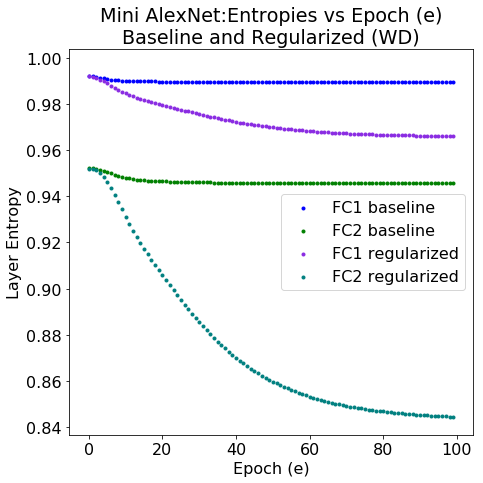

In [12]:
plt.scatter(range(0,len(fc1_entropies)), fc1_entropies, marker='.', color='blue',label="FC1 baseline")
plt.scatter(range(0,len(fc2_entropies)), fc2_entropies, marker='.', color='green',label="FC2 baseline")
plt.scatter(range(0,len(fc1_wd_entropies)), fc1_wd_entropies, marker='.', color='blueviolet', label="FC1 regularized")
plt.scatter(range(0,len(fc2_wd_entropies)), fc2_wd_entropies, marker='.', color='teal', label="FC2 regularized")
plt.title('Mini AlexNet:Entropies vs Epoch (e)\nBaseline and Regularized (WD)')
plt.xlabel("Epoch (e)")
plt.ylabel("Layer Entropy")
plt.legend()
plt.tight_layout()

plt.savefig(ENTROPY_FILE)
print("saved file {}".format(ENTROPY_FILE))

### Stable Ranks

saved file img/mini-alexnet-wd-rank-per-epoch.png


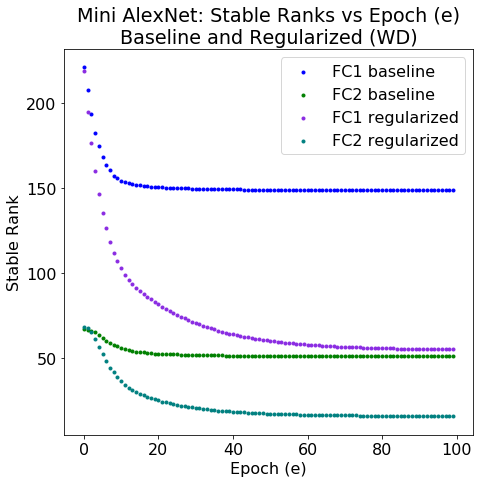

In [13]:
plt.scatter(range(0,len(fc1_ranks)), fc1_ranks, marker='.', color='blue',label="FC1 baseline")
plt.scatter(range(0,len(fc2_ranks)), fc2_ranks, marker='.', color='green',label="FC2 baseline")
plt.scatter(range(0,len(fc1_wd_ranks)), fc1_wd_ranks, marker='.', color='blueviolet', label="FC1 regularized")
plt.scatter(range(0,len(fc2_wd_ranks)), fc2_wd_ranks, marker='.', color='teal', label="FC2 regularized")
plt.title('Mini AlexNet: Stable Ranks vs Epoch (e)\nBaseline and Regularized (WD)')
plt.xlabel("Epoch (e)")
plt.ylabel("Stable Rank")
plt.legend()
plt.tight_layout()

plt.savefig(RANK_FILE)
print("saved file {}".format(RANK_FILE))


### Compare Training accuracies from output file

No real difference

In [14]:
bsln_train_accs = RMT_Util.read_training_accuracies(BASELINE_outfile)
assert(len(bsln_train_accs)==NUM_BASELINE_EPOCHS)

In [15]:
wd_train_accs = RMT_Util.read_training_accuracies(REGULARIZED_outfile)
assert(len(wd_train_accs)==NUM_BASELINE_EPOCHS)

### Training and test Accuracies vs Epoch

In [16]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

/Users/charleshmartin/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py:1645: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [17]:
test_images, test_labels = RMT_Util.read_test_images(datadir=DATA_DIR)

Loading test images...


In [18]:
bsln_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(test_images),np.array(test_labels), batch_size=256)
    bsln_test_accs.append(acc[1])

10000/10000 [==============================] - 9s 883us/step



In [19]:

wd_test_accs = []
for epoch in tqdm(range(NUM_BASELINE_EPOCHS)):
    modelfile = BASELINE_per_epoch_weightfile.format(epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(test_images),np.array(test_labels), batch_size=256)
    wd_test_accs.append(acc[1])

10000/10000 [==============================] - 9s 875us/step



In [20]:
plt.rcParams['figure.figsize'] = [5,5]
matplotlib.rcParams.update({'font.size': 16})

saved file img/mini-alexnet-wd-accuracy-per-epoch.png


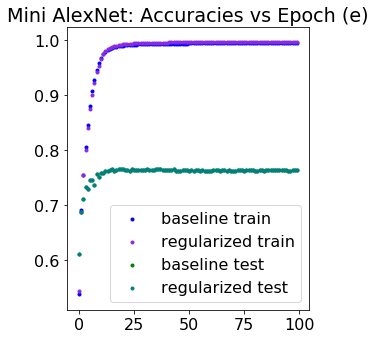

In [21]:
x = range(NUM_BASELINE_EPOCHS)

plt.scatter(x, bsln_train_accs,  marker='.',color='blue', label="baseline train")
plt.scatter(x, wd_train_accs,  marker='.',color='blueviolet', label='regularized train')

plt.scatter(x, bsln_test_accs,  marker='.',color='green', label="baseline test")
plt.scatter(x, wd_test_accs,  marker='.',color='teal', label='regularized test')

plt.title('Mini AlexNet: Accuracies vs Epoch (e)')
plt.legend()
plt.tight_layout()

plt.savefig(ACCURACY_FILE)
print("saved file {}".format(ACCURACY_FILE))

#### Test accuracy for regularized version is a little better

0.7630 vs 0.7740


In [22]:
!tail -1 $BASELINE_outfile

[0.036127942806482315, 0.76300000000000001]


In [23]:
!tail -1$REGULARIZED_outfile

tail: illegal option -- -1/Users/charleshmartin/work-tmp/MiniAlexNet/results/cifar10_alexnet.id1.wd.out


## ESD Plots

### Layer 8 fits MP with reduced rank, but layer 7 does not fit at all

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 5.49
% sigma 0.2903
saved figure img/mini-alexnet-wd-fc2.png


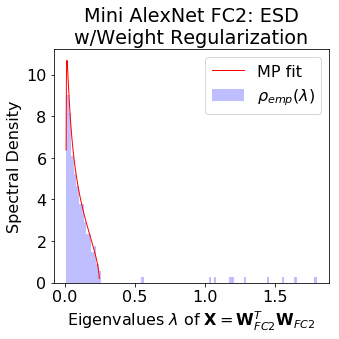

In [24]:
weightfile = REGULARIZED_final_weightfile

RMT_Util.plot_ESD_and_fit(model=model, weightfile=weightfile, layer=LAYER_FC2, 
                            Q=Q8, num_spikes=10, sigma=None, color='blue')


plt.title(TITLE_FC2)
plt.xlabel(XLABEL_FC2)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=FC2_FILENAME
plt.savefig(filename)
print("saved figure {}".format(filename))

### Bleeding out and spikes

RMT_Util.ipynb:7: RuntimeWarning: divide by zero encountered in true_divide
  "## RMT Util\n",
RMT_Util.ipynb:7: RuntimeWarning: invalid value encountered in sqrt
  "## RMT Util\n",


% spikes outside bulk 8.47
% sigma 0.3814
saved figure img/mini-alexnet-wd-fc1.png


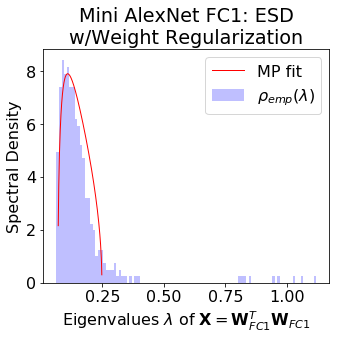

In [25]:
weightfile = REGULARIZED_final_weightfile

RMT_Util.plot_ESD_and_fit(model=model, weightfile=weightfile, layer=LAYER_FC1, 
                            Q=Q7, num_spikes=30, sigma=None, color='blue')


plt.title(TITLE_FC1)
plt.xlabel(XLABEL_FC1)
plt.ylabel(YLABEL)
plt.legend()
plt.tight_layout()

filename=FC1_FILENAME
plt.savefig(filename)
print("saved figure {}".format(filename))

## Scree Plots:  

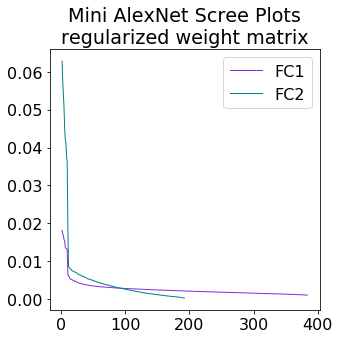

In [26]:
RMT_Util.scree_plot(model, REGULARIZED_final_weightfile, layer=LAYER_FC1, color='blueviolet', label="FC1")
RMT_Util.scree_plot(model, REGULARIZED_final_weightfile, layer=LAYER_FC2, color='teal', label="FC2")
plt.title("Mini AlexNet Scree Plots\nregularized weight matrix")
plt.legend()
plt.tight_layout()
plt.show()

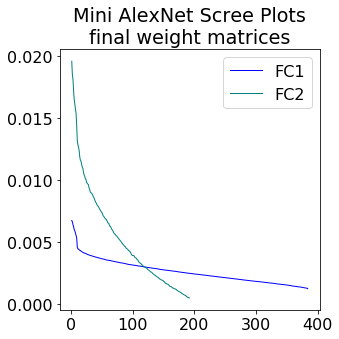

In [27]:
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=LAYER_FC1, color='blue', label="FC1")
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=LAYER_FC2, color='teal', label="FC2")
plt.title("Mini AlexNet Scree Plots\nfinal weight matrices")
plt.legend()
plt.tight_layout()
plt.show()

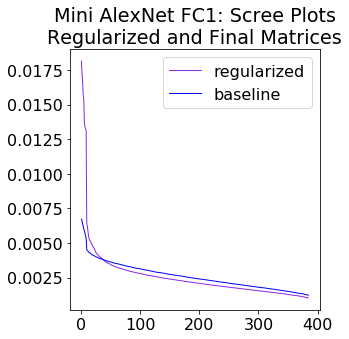

In [28]:
RMT_Util.scree_plot(model, REGULARIZED_final_weightfile, layer=LAYER_FC1, color='blueviolet', label="regularized")
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=LAYER_FC1, color='blue', label="baseline")
plt.title("Mini AlexNet FC1: Scree Plots\nRegularized and Final Matrices")
plt.legend()
plt.tight_layout()
plt.show()

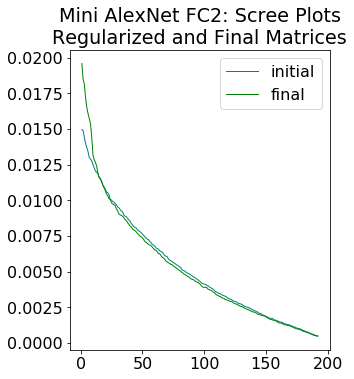

In [29]:
RMT_Util.scree_plot(model, BASELINE_init_weighfile, layer=LAYER_FC2, color='teal', label="initial")
RMT_Util.scree_plot(model, BASELINE_final_weightfile, layer=LAYER_FC2, color='green', label="final")
plt.legend()
plt.tight_layout()
plt.title("Mini AlexNet FC2: Scree Plots\nRegularized and Final Matrices")
plt.show()